Import necessary libraries

In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


In [106]:
# load mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension
x_test = np.expand_dims(x_test, -1)


In [78]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# I have also tried U-Net architecture - works better, convergates in 1st
# epoch, just the epoch takes longer. But the teacher wanted us to design
# "our own" architecture so I think its fine to rather continue with this one

def build_cae():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    latent = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(latent)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(encoder_input, decoder_output)


In [80]:
# code to construcst dae
def build_dae():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    latent = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(latent)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(encoder_input, decoder_output)


In [102]:
# evaluation functions
from sklearn.metrics import mean_squared_error

def evaluate_model(model, x_test, x_test_noisy=None):
    x_test_input = x_test_noisy if x_test_noisy is not None else x_test
    x_reconstructed = model.predict(x_test_input)
    mse = mean_squared_error(x_test.flatten(), x_reconstructed.flatten())
    return mse

def plot_loss(history, title):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def visualize_reconstruction(model, x_test, n=10):
    x_reconstructed = model.predict(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Reconstructed
        plt.subplot(2, n, i + n + 1)
        plt.imshow(x_reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()


In [82]:
# first step -> train cae
# Training parameters
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile and train each model
cae = build_cae()

# I have tried training the model with mse (first recommendation of gpt), but it
# was shit, now constructing anything -> I've switcher t binary_crossentropy and
# now its good
# cae.compile(optimizer='adam', loss='mse')

cae.compile(optimizer='adam', loss='binary_crossentropy')

cae_history = cae.fit(x_train, x_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_test, x_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2341 - val_loss: 0.0892
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0884 - val_loss: 0.0836
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0836 - val_loss: 0.0809
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0812 - val_loss: 0.0793
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0800 - val_loss: 0.0786


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CAE MSE: 0.005884358659386635


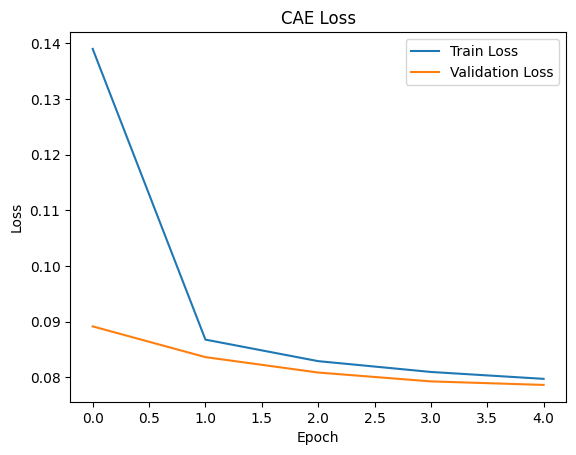

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


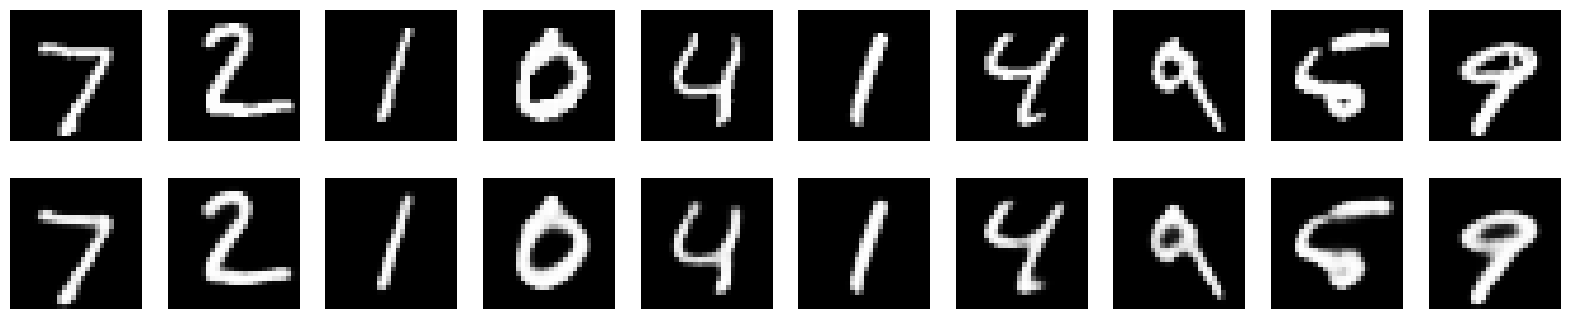

In [83]:
cae_mse = evaluate_model(cae, x_test)
print(f"CAE MSE: {cae_mse}")
plot_loss(cae_history, "CAE Loss")
visualize_reconstruction(cae, x_test)


# I quite like the results here, mostly the visualization. You can see that
# it works good, but such small and random model cannot check the little
# mistakes / noise - it recongises and reconstruct 5, but skips the litle gap
# from the original drawing


In [92]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Add noise for DAE
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# again, mse didn't work but binary crossentropy brings really nice results

dae = build_dae()
dae.compile(optimizer=optimizer, loss="binary_crossentropy")
dae_history = dae.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), batch_size=128, epochs=10)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2247 - val_loss: 0.1074
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1069 - val_loss: 0.1038
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1035 - val_loss: 0.1011
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1011 - val_loss: 0.0989
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0992 - val_loss: 0.0977
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0979 - val_loss: 0.0975
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0975 - val_loss: 0.0962
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0967 - val_loss: 0.0960
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0963 - val_loss: 0.0952
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0956 - val_loss: 0.0950


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DAE MSE 0.01059682760387659


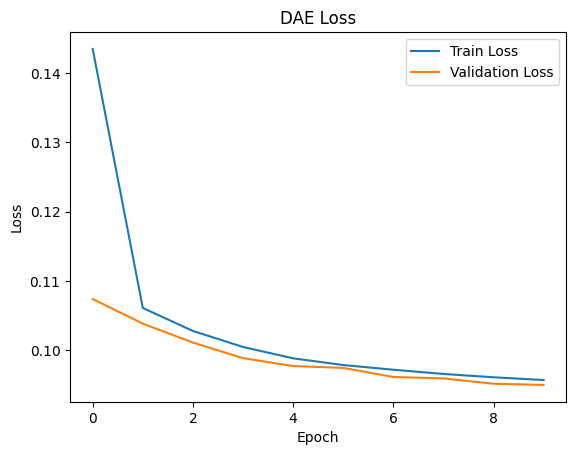

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


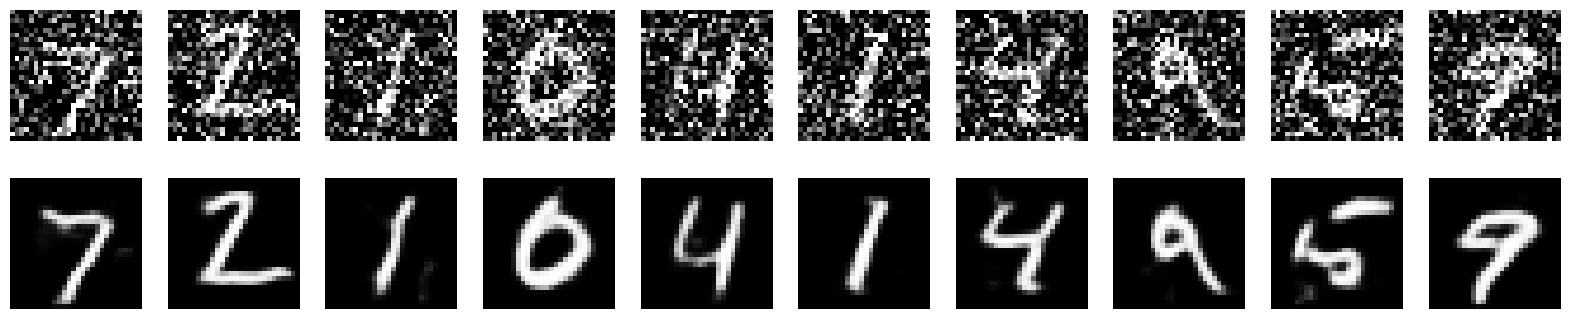

In [103]:
dae_mse = evaluate_model(dae, x_test, x_test_noisy)
print(f"DAE MSE {dae_mse}")
plot_loss(dae_history, "DAE Loss")
visualize_reconstruction(dae, x_test_noisy)


In [112]:
def build_vae():
    latent_dim = 2

    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(decoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(28 * 28, activation="sigmoid")(x)
    decoder_output = layers.Reshape((28, 28, 1))(x)
    decoder = models.Model(decoder_input, decoder_output, name="decoder")

    # VAE Model
    vae_output = decoder(encoder(encoder_input)[2])
    vae = models.Model(encoder_input, vae_output, name="vae")

    # # Loss function
    # reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
    # kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    # vae.add_loss(reconstruction_loss + kl_loss)
    return vae

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
vae = build_vae()
vae.compile(optimizer=optimizer, loss="binary_crossentropy")
vae_history = vae.fit(x_train, x_train, validation_data=(x_test, x_test), batch_size=128, epochs=20)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2920 - val_loss: 0.2086
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2035 - val_loss: 0.1920
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1906 - val_loss: 0.1872
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1864 - val_loss: 0.1840
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1836 - val_loss: 0.1822
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1814 - val_loss: 0.1815
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1797 - val_loss: 0.1795
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1784 - val_loss: 0.1785
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1770 - val_loss: 0.1775
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1760 - val_loss: 0.1769
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1748 - val_loss: 0.1760
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
VAE MSE: 0.037012502551078796


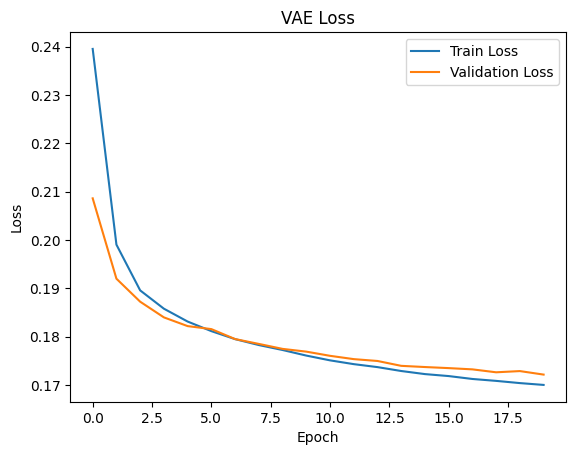

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


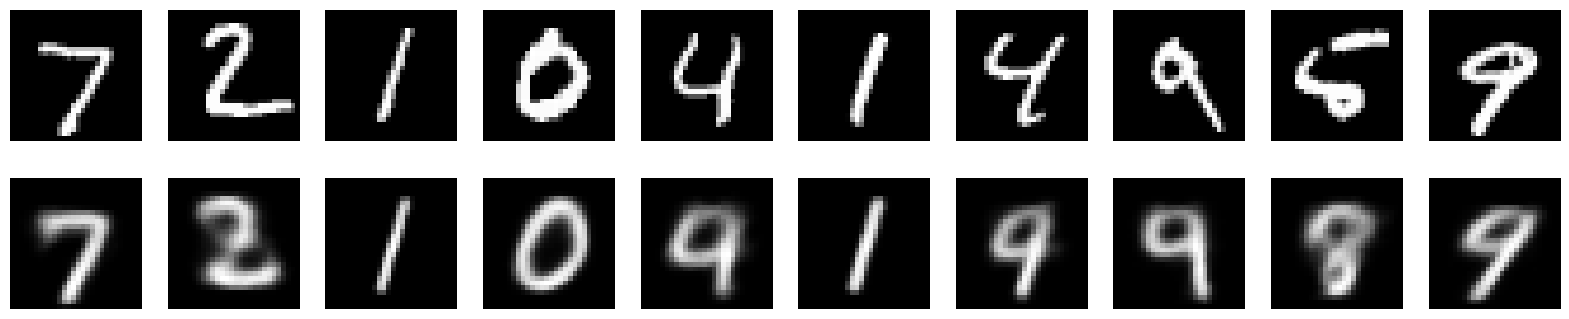

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


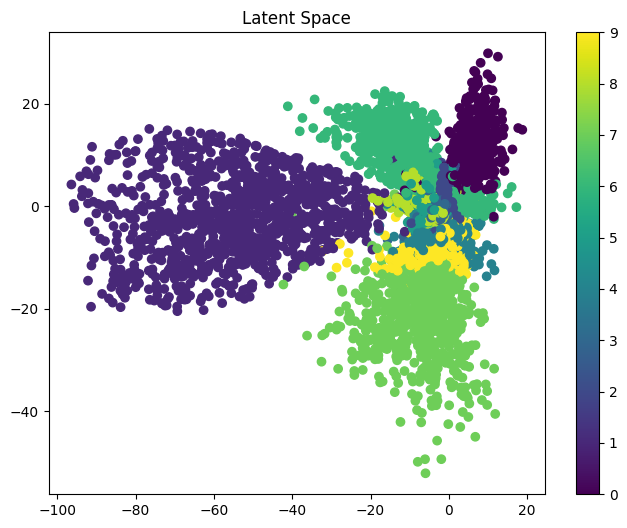

In [113]:
vae_mse = evaluate_model(vae, x_test)
print(f"VAE MSE: {vae_mse}")
plot_loss(vae_history, "VAE Loss")
visualize_reconstruction(vae, x_test)
# Latent space visualization for VAE
def visualize_latent_space(vae, x_test, y_test):
    encoder = vae.get_layer("encoder")
    z_mean, _, _ = encoder.predict(x_test)

    # If y_test is not one-hot encoded, use it directly as class labels
    if len(y_test.shape) == 1:  # If it's already in integer format (0-9)
        labels = y_test
    else:  # If it's one-hot encoded, convert it to class labels
        labels = np.argmax(y_test, axis=1)

    # Plot latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="viridis")
    plt.colorbar()
    plt.title("Latent Space")
    plt.show()

# here could be worth visualiza the latent space after 5 epochs and after more,
# the difference is nice and significant
# Visualize the latent space for VAE
visualize_latent_space(vae, x_test, y_test)
